# **Competition Hology 7.0 Data Mining**

## 1. Setup and Installation
Menginstal modul gdown yang akan digunakan untuk mendownload file dari Google Drive menggunakan ID file, dan mengimport library yang akan digunakan untuk membuat model prediksi.

In [1]:
!pip install gdown

In [ ]:
import gdown
import zipfile
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models, layers, backend as K
from sklearn.metrics import accuracy_score, f1_score

## 2. Data Downloading and Extraction
Mendownload dataset menggunakan gdown dari Google Drive dan mengekstrak file ZIP, setelah itu menghapus file ZIP untuk membantu menghemat ruang penyimpanan.

In [2]:
url = "https://drive.google.com/uc?id=1TbHce2SU-W_Fr2hMjN9E_WhC_1R9M182"
output = 'Penyisiha_Hology_Data_Mining.zip'
gdown.download(url, output, quiet=False)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall()
os.remove(output)

Downloading...
From: https://drive.google.com/uc?id=1TbHce2SU-W_Fr2hMjN9E_WhC_1R9M182
To: /kaggle/working/Penyisiha_Hology_Data_Mining.zip
100%|██████████| 10.2M/10.2M [00:00<00:00, 170MB/s]


### 3. Data Loading
Memuat file gambar dari folder train dan test 

In [3]:
train_images = os.listdir(os.path.join('Penyisihan Hology Data Mining', 'train'))
test_images = os.listdir(os.path.join('Penyisihan Hology Data Mining', 'test'))

## 4. Data Visualization
Menampilkan beberapa contoh gambar dari folder train

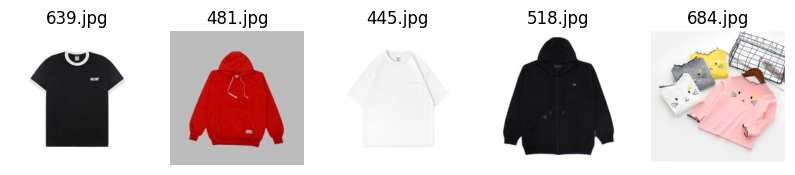

In [4]:
num_images_to_show = 5
plt.figure(figsize=(10, 10))
for i, image_file in enumerate(train_images[:num_images_to_show]):
    img_path = os.path.join('Penyisihan Hology Data Mining', 'train', image_file)
    img = Image.open(img_path)

    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(img)
    plt.title(image_file)
    plt.axis('off')

plt.show()

## 5. Data Preprocessing

### 5.1 Label Encoding
Membaca file train.csv yang berisi label untuk gambar, lalu membuat vektor encoding untuk setiap label. Jenis produk dan warna dienkode dalam vektor array 2D untuk digunakan dalam pelatihan model.

In [5]:
csv_path = os.path.join('Penyisihan Hology Data Mining', 'train.csv')
df = pd.read_csv(csv_path)

def encode_labels(row):
    encoded_vector = np.zeros(7, dtype=int)
    if row['jenis'] == 0:
        encoded_vector[0] = 1
    elif row['jenis'] == 1:
        encoded_vector[1] = 1

    encoded_vector[2 + row['warna']] = 1
    return encoded_vector

df['encoded_labels'] = df.apply(encode_labels, axis=1)

print(df[['id', 'encoded_labels']].head())

   id         encoded_labels

0   1  [0, 1, 0, 1, 0, 0, 0]

1   2  [1, 0, 0, 0, 1, 0, 0]

2   3  [0, 1, 0, 0, 0, 1, 0]

3   4  [0, 1, 0, 1, 0, 0, 0]

4   5  [1, 0, 0, 0, 0, 0, 1]


### 5.2 Mapping Labels to Image IDs
Memasangkan setiap gambar dengan ID-nya dan label yang sudah diencode, kemudian menampilkan sample gambar dengan label mereka.

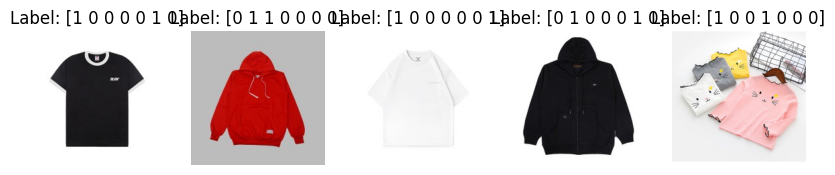

In [7]:
image_folder = 'Penyisihan Hology Data Mining/train'
image_paths = [os.path.join(image_folder, img) for img in train_images]

encoded_labels = np.stack(df['encoded_labels'].values)

df['encoded_labels'] = df.apply(encode_labels, axis=1)
id_to_label = {row['id']: row['encoded_labels'] for _, row in df.iterrows()}

# path fotonya
image_folder = 'Penyisihan Hology Data Mining/train'
train_images = os.listdir(image_folder)

image_paths = []
encoded_labels = []

# nyocokin foto sama label by id
for image_file in train_images:
    img_id = int(os.path.splitext(image_file)[0])

    if img_id in id_to_label:
        img_path = os.path.join(image_folder, image_file)
        image_paths.append(img_path)
        encoded_labels.append(id_to_label[img_id])

# ubah ke np
encoded_labels = np.array(encoded_labels)

num_images_to_show = 5
plt.figure(figsize=(10, 10))
for i, img_path in enumerate(image_paths[:num_images_to_show]):
    img = Image.open(img_path)
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {encoded_labels[i]}")
    plt.axis('off')

plt.show()

## 6. Model Preparation

### 6.1 Loading and Resizing Images
Mengonversi gambar menjadi array numpy setelah diubah ukurannya ke 224x224.

### 6.2 Splitting Data for Training and Validation
Membagi data menjadi set pelatihan dan validasi dengan rasio 70:30.

In [8]:
image_size = (224, 224)
num_classes = 7

def load_images(image_paths):
    images = []
    for path in image_paths:
        img = Image.open(path).convert('RGB')
        img = img.resize(image_size)
        images.append(np.array(img))
    return np.array(images)

image_folder = 'Penyisihan Hology Data Mining/train'
train_images = os.listdir(image_folder)
image_paths = [os.path.join(image_folder, img) for img in train_images]

X_train = load_images(image_paths)
y_train = encoded_labels

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


## 7. Data Augmentation
Menambah kumpulan data pelatihan untuk meningkatkan generalisasi model dengan menerapkan transformasi acak seperti rotasi, pergeseran, dan pembalikan.

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

## 8. Model Building
Menentukan Exact Match Ratio metric untuk menilai akurasi multilabel prediction. Serta meng-compile model dengan optimizer Adam dan binary cross-entropy loss untuk multilabel classification. Kemudian menggunakan model ResNet50 sebagai feature extractor serta menambahkan lapisan untuk multilabel classification dengan final sigmoid activation untuk class probabilities.

In [11]:
image_size = (224, 224)
num_classes = 7

# ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))
base_model.trainable = Fals

# layer" model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='sigmoid') 
])

# bikin emr
def exact_match_ratio(y_true, y_pred):
    y_pred = K.cast(y_pred > 0.5, dtype='float32')
    y_true = K.cast(y_true, dtype='float32')
    matches = K.all(K.equal(y_true, y_pred), axis=-1)
    return K.mean(K.cast(matches, dtype='float32'))


# compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',  # Use 'sparse_categorical_crossentropy' for single-label
    metrics=['accuracy', exact_match_ratio]
)

# sample weighting
class_weights = {0: 1.0, 1: 1.0, 2: 2.0, 3: 2.0, 4: 2.0, 5: 1.0, 6: 1.0}

sample_weights = np.ones(len(y_train))
for i, labels in enumerate(y_train):
    sample_weights[i] = sum([class_weights.get(class_id, 1.0) for class_id, present in enumerate(labels) if present == 1])

# training model
model.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32
)

Epoch 1/25



I0000 00:00:1730025391.566495      79 service.cc:145] XLA service 0x7bfdbc054830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:

I0000 00:00:1730025391.566544      79 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5

I0000 00:00:1730025391.566549      79 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/17 ━━━━━━━━━━━━━━━━━━━━ 4:10 16s/step - accuracy: 0.0938 - exact_match_ratio: 0.0000e+00 - loss: 2.4734

I0000 00:00:1730025399.384647      79 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/17 ━━━━━━━━━━━━━━━━━━━━ 30s 920ms/step - accuracy: 0.3598 - exact_match_ratio: 0.0140 - loss: 1.8153 - val_accuracy: 0.8547 - val_exact_match_ratio: 0.0898 - val_loss: 0.4250

Epoch 2/25

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.7696 - exact_match_ratio: 0.1552 - loss: 1.0688 - val_accuracy: 0.8846 - val_exact_match_ratio: 0.3016 - val_loss: 0.3216

Epoch 3/25

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.8079 - exact_match_ratio: 0.3343 - loss: 0.8241 - val_accuracy: 0.8333 - val_exact_match_ratio: 0.4289 - val_loss: 0.2649

Epoch 4/25

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.8138 - exact_match_ratio: 0.5319 - loss: 0.6532 - val_accuracy: 0.8205 - val_exact_match_ratio: 0.5523 - val_loss: 0.2334

Epoch 5/25

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.7951 - exact_match_ratio: 0.5899 - loss: 0.5688 - val_accuracy: 0.8291 - val_exact_match_ratio: 0.6117 - val_loss: 0.2164

Epoch 6/25

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accura

## 9. Model Training
Menyesuaikan sample weight berdasarkan class frequency dan melatih model pada data training menggunakan data validasi untuk evaluasi berkala.

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 570ms/step


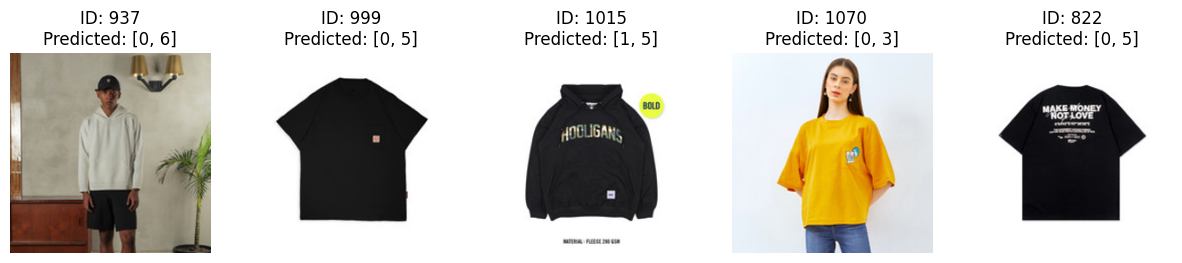

In [12]:
test_image_folder = 'Penyisihan Hology Data Mining/test'
image_size = (224, 224)
num_classes = 7

def load_test_images(image_folder):
    test_images = os.listdir(image_folder)
    image_paths = [os.path.join(image_folder, img) for img in test_images]

    images = []
    valid_image_files = []
    for path in image_paths:
        try:
            img = Image.open(path).convert('RGB')
            img = img.resize(image_size)
            images.append(np.array(img))
            valid_image_files.append(path)
        except Exception as e:
            print(f"Error loading image {path}: {e}")
    return np.array(images), test_images

X_test, test_image_files = load_test_images(test_image_folder)

predicted_labels = model.predict(X_test)
plt.figure(figsize=(15, 15))
for i in range(min(num_images_to_show, len(X_test))):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(X_test[i].astype("uint8"))

    image_id = os.path.splitext(os.path.basename(test_image_files[i]))[0]

    label_indices = np.where(predicted_labels[i] >= 0.5)[0]
    label_text = ", ".join(str(idx) for idx in label_indices)

    plt.title(f"ID: {image_id}\nPredicted: [{label_text}]")
    plt.axis('off')

plt.show()

## 10. Evaluation and Prediction
Menghitung accuracy, F1-score, dan Exact Match Ratio untuk validation prediction.

In [13]:
val_predictions = model.predict(X_val)
val_predictions = (val_predictions > 0.4).astype(int)

accuracy = accuracy_score(y_val, val_predictions)

f1 = f1_score(y_val, val_predictions, average='macro')

def exact_match_ratio(y_true, y_pred):
    return np.mean(np.all(y_true == y_pred, axis=1))

emr = exact_match_ratio(y_val, val_predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Exact Match Ratio: {emr:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step

Accuracy: 0.8034

F1 Score: 0.9024

Exact Match Ratio: 0.8034


## 11. Exporting Predictions
Menyimpan model prediction kedalam CSV agar mudah di review.

In [14]:
num_jenis_classes = 2
num_warna_classes = 5

jenis_predicted_indices = np.argmax(predicted_labels[:, :num_jenis_classes], axis=1)
warna_predicted_indices = np.argmax(predicted_labels[:, num_jenis_classes:], axis=1)

output_df = pd.DataFrame({
    'id': [os.path.splitext(os.path.basename(file))[0] for file in test_image_files],
    'jenis': jenis_predicted_indices,
    'warna': warna_predicted_indices,
})

output_csv_path = "submission.csv"
output_df.to_csv(output_csv_path, index=False)
print(f"Predictions exported to {output_csv_path}")


Predictions exported to submission.csv
